# XGBoost 를 이용한 통신사의 고객 이탈 여부 예측  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Data 불러오기

In [2]:
pd.set_option('display.max_columns',None)
df = pd.read_csv("data/Telco_Customer_Churn.csv")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [3]:
df.shape

(7043, 33)

In [4]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

- 'Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'의 4 개 column은 탈회 이유를 사후에 interview한 것이므로 column 삭제

In [5]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis=1, inplace=True)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


- object column 의 통계 조회

In [6]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000


In [7]:
df.describe(include='O')

,CustomerID,Country,State,City,Lat Long,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Total Charges
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,1,1,1129,1652,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531
top,4355-HBJHH,United States,California,Los Angeles,"34.072121, -117.698319",Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2
freq,1,7043,7043,305,5,3555,5901,3641,5416,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11


- unique value를 가진 column 은 분류에 도움되지 않으므로 삭제

In [8]:
df['Count'].value_counts()

1    7043
Name: Count, dtype: int64

In [9]:
df['Country'].unique(), df['State'].unique()

(array(['United States'], dtype=object), array(['California'], dtype=object))

- 'Customer ID' 도 분류에 도움되지 않으므로 삭제

- 'Lat Long'은 'Latitude'와 'Longitude' 별도 column으로 구분되어 있으므로 삭제

In [10]:
df.drop(['CustomerID','Count', 'Country', 'State', 'Lat Long'], axis=1, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


### Column 명 내의 white space 처리

In [11]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

### Missing Value 존재 check

In [12]:
df.isnull().sum()

City                 0
Zip_Code             0
Latitude             0
Longitude            0
Gender               0
Senior_Citizen       0
Partner              0
Dependents           0
Tenure_Months        0
Phone_Service        0
Multiple_Lines       0
Internet_Service     0
Online_Security      0
Online_Backup        0
Device_Protection    0
Tech_Support         0
Streaming_TV         0
Streaming_Movies     0
Contract             0
Paperless_Billing    0
Payment_Method       0
Monthly_Charges      0
Total_Charges        0
Churn_Value          0
dtype: int64

In [13]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

- Total_Charges는 numeric data 인데 object로 되어 있으므로 numeric column으로 바꾸어 준다.  

- space 의 경우 0 으로 채움

In [14]:
df.loc[(df['Total_Charges'] == ' ')]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [15]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0

In [16]:
df.loc[(df['Total_Charges'] == ' ')]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value


In [17]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

In [18]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

XGBoost tree 시각화를 위해 모든 data의 space를 `_`로 바꾸어 준다.

In [19]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


### XGBoost 에 맞도록  Data Formatting
- 독립, 종속 변수 분리  

- One-hot-encoding

- 모든 column 들을 int, float, bool 로 convert

In [20]:
X = df.drop('Churn_Value', axis=1).copy()
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [21]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

In [22]:
y.unique()

array([1, 0])

In [23]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

In [24]:
X.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges'],
      dtype='object')

In [25]:
categorical_columns = ['City', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method']

In [26]:
pd.set_option('display.max.columns', 30)
X_encoded = pd.get_dummies(X, columns=categorical_columns)
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,...,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0


- label value의 편향성을 check하여 불균형이 클 경우 train set과 test set의 분포를 동일하게 유지하기 위해 층화추출법을 적용

In [27]:
# y 중의 label = 1 인 비율
sum(y) / len(y)

0.2653698707936959

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, 
                                stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 1178), (1761, 1178), (5282,), (1761,))

`label = 1`의 비율이 유지 되었는지 확인

In [29]:
sum(y_train)/len(y_train), sum(y_test)/len(y_test)

(0.2654297614539947, 0.26519023282226006)

### XGBoost 초기 model 작성

In [30]:
clf_xgb_1 = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb_1.fit(X_train, y_train, verbose=True, 
            early_stopping_rounds=10, #tree 10개를 추가해도 성능 개선 없으면 stop
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

/Users/ohyoungjea/anaconda3/envs/tf20/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64404
[2]	validation_0-aucpr:0.65124
[3]	validation_0-aucpr:0.65051
[4]	validation_0-aucpr:0.65321
[5]	validation_0-aucpr:0.64854
[6]	validation_0-aucpr:0.65459
[7]	validation_0-aucpr:0.65895
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65850
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66527
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66000
[15]	validation_0-aucpr:0.66027
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65593
[18]	validation_0-aucpr:0.65738
[19]	validation_0-aucpr:0.65829
[20]	validation_0-aucpr:0.65683


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

- `balanced_accuracy_score` : 
불균형 데이터 세트를 처리하기 위한 이진 및 다중 클래스 분류 문제의 균형 잡힌 정확도. 각 클래스에서 얻은 recall의 평균으로 정의됩니다.

In [31]:
from sklearn.metrics import balanced_accuracy_score, recall_score,\
                precision_score, accuracy_score

y_pred = clf_xgb_1.predict(X_test)

print("accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("balanced_accuracy: {:.2f}".format(balanced_accuracy_score(y_test, y_pred)))
print("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("recall: {:.2f}".format(recall_score(y_test, y_pred)))

accuracy: 0.81
balanced_accuracy: 0.72
precision: 0.67
recall: 0.55


### Cross Validation 과 Grid Search로 Parameter 최적화
- learning rate, tree 깊이, tree 수, gamma(pruning), lambda (regularization)

- 초기 grid search

In [32]:
param_grid = {'max_depth': [3, 4],
             'learning_rate': [0.1, 0.01],
             'gamma': [0, 0.25],
             'reg_lambda': [0, 1.0, 10.0],
             'scale_pos_weight': [1, 3]}  # positive, negative weight의 balance

- grid search (약 3~5 분 소요)

In [33]:
%%time
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42, 
                subsample=0.9,  #overfitting 방지를 위해 data의 90%만 사용
                #overfitting 방지를 위해 tree 당 column의 50%만 random하게 선택
                colsample_bytree=0.5), 
    param_grid = param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train, y_train, 
                   early_stopping_rounds=10,
                   eval_metric='auc', eval_set=[(X_test, y_test)],
                   verbose=False)

print(optimal_params.best_params_)

/Users/ohyoungjea/anaconda3/envs/tf20/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 3}
CPU times: user 25.5 s, sys: 1.02 s, total: 26.5 s
Wall time: 2min 56s


- 초기 search 결과를 바탕으로 범위를 좁혀서 search

In [34]:
param_grid = {'max_depth': [4],
             'learning_rate': [0.1, 0.5, 1],
             'gamma': [0.25],
             'reg_lambda': [10.0, 20],
             'scale_pos_weight': [3]}

In [35]:
%%time
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42, 
                subsample=0.9,  #overfitting 방지를 위해 data의 90%만 사용
                #overfitting 방지를 위해 tree 당 column의 50%만 random하게 선택
                colsample_bytree=0.5), 
    param_grid = param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train, y_train, 
                   early_stopping_rounds=10,
                   eval_metric='auc', eval_set=[(X_test, y_test)],
                   verbose=False)

print(optimal_params.best_params_)

/Users/ohyoungjea/anaconda3/envs/tf20/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 3}
CPU times: user 24.9 s, sys: 781 ms, total: 25.7 s
Wall time: 16.6 s


### Optimal XGBoost model 작성 및 평가, 시각화

In [36]:
clf_xgb_2 = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                           gamma=0.25, learning_rate=0.1,
                           max_depth=4, reg_lambda=10.0,
                           scale_pos_weight=3, 
                           subsample=0.9,
                           colsample_bytree=0.5)
clf_xgb_2.fit(X_train, y_train,
           verbose=True, early_stopping_rounds=10,
           eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.55001
[1]	validation_0-aucpr:0.56932
[2]	validation_0-aucpr:0.60830
[3]	validation_0-aucpr:0.61361
[4]	validation_0-aucpr:0.61895
[5]	validation_0-aucpr:0.62025
[6]	validation_0-aucpr:0.62607
[7]	validation_0-aucpr:0.62667
[8]	validation_0-aucpr:0.63455
[9]	validation_0-aucpr:0.63476
[10]	validation_0-aucpr:0.63491
[11]	validation_0-aucpr:0.63240
[12]	validation_0-aucpr:0.63346
[13]	validation_0-aucpr:0.63336
[14]	validation_0-aucpr:0.63233
[15]	validation_0-aucpr:0.63323
[16]	validation_0-aucpr:0.63119
[17]	validation_0-aucpr:0.63158
[18]	validation_0-aucpr:0.63909
[19]	validation_0-aucpr:0.63952
[20]	validation_0-aucpr:0.65137
[21]	validation_0-aucpr:0.65583
[22]	validation_0-aucpr:0.65661
[23]	validation_0-aucpr:0.65585
[24]	validation_0-aucpr:0.65636
[25]	validation_0-aucpr:0.65873
[26]	validation_0-aucpr:0.65922
[27]	validation_0-aucpr:0.65938
[28]	validation_0-aucpr:0.66044
[29]	validation_0-aucpr:0.66150
[30]	validation_0-aucpr:0.66144
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [37]:
y_pred = clf_xgb_2.predict(X_test)

print("accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("balanced_accuracy: {:.2f}".format(balanced_accuracy_score(y_test, y_pred)))
print("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("recall: {:.2f}".format(recall_score(y_test, y_pred)))

accuracy: 0.75
balanced_accuracy: 0.78
precision: 0.52
recall: 0.84


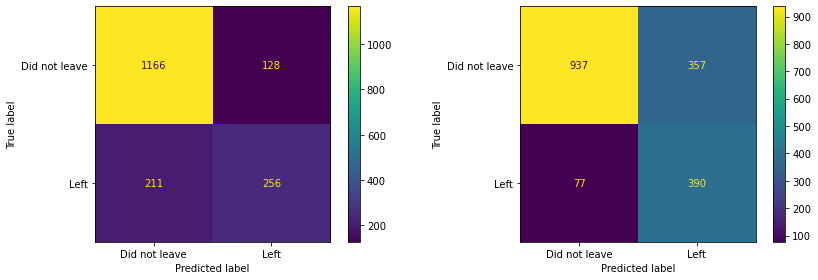

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_confusion_matrix(clf_xgb_1, X_test, y_test, values_format='d',
                     display_labels=['Did not leave', 'Left'], ax=ax1)

plot_confusion_matrix(clf_xgb_2, X_test, y_test, values_format='d',
                     display_labels=['Did not leave', 'Left'], ax=ax2)
plt.tight_layout()

- optimize 된 model 은 `탈회 고객(Left)`을 더 잘 예측하는 대신 이전 model에 비해 `Did not leave` 도 `Left`로 더 많이 분류  

- 회사 입장에서 탈회 않을 고객을 미리 잘 해주어 크게 손해 볼 것 없으므로 이전 model 보다 지금의 model이 더 탈회 고객 사전 관리에 유리하다.

### XGBoost Tree 시각화

- first tree 만 생성

In [39]:
clf_xgb = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                           gamma=0.25, learning_rate=0.1,
                           max_depth=4, reg_lambda=10.0,
                           scale_pos_weight=3, 
                           subsample=0.9,
                           colsample_bytree=0.5,
                           n_estimators=1)  
clf_xgb.fit(X_train, y_train)

/Users/ohyoungjea/anaconda3/envs/tf20/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

* 'weight': 모든 트리에서 데이터를 분할하는 데 특성이 사용된 횟수입니다.
* 'gain': 특성이 사용되는 모든 분할에 대한 평균 gain.
* 'cover': 그 특성이 사용되는 모든 분할에 대한 평균 적용 범위.
* 'total_gain': 특성이 사용되는 모든 분할에 대한 총 이득.
* 'total_cover': 특성이 사용되는 모든 분할에 대한 총 적용 범위.

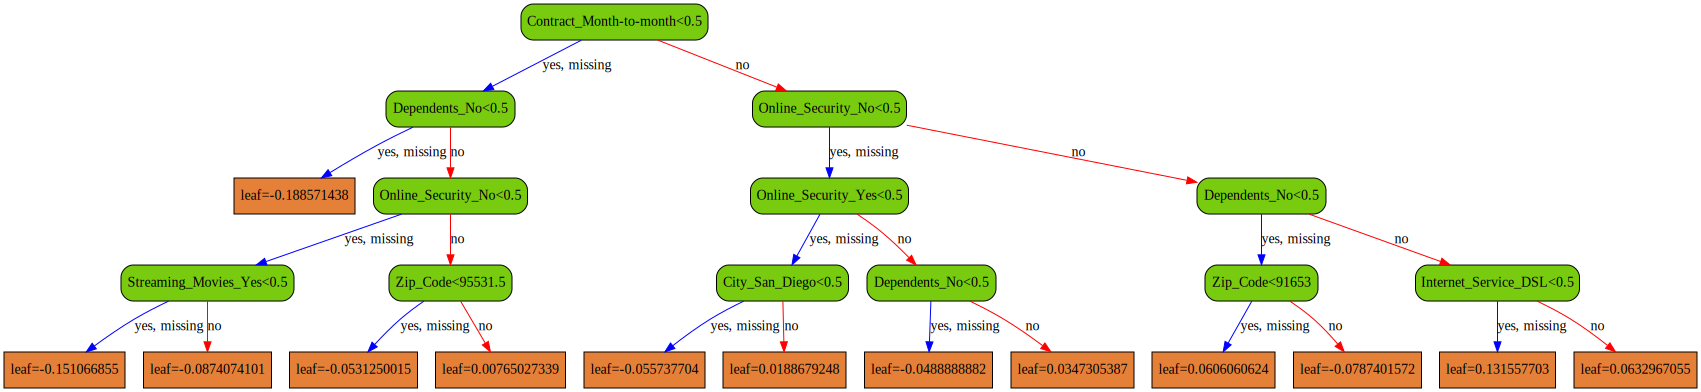

In [40]:
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10, 10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

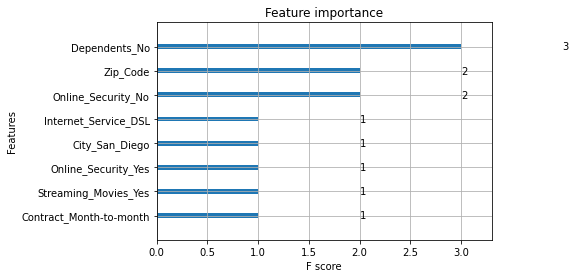

In [41]:
xgb.plot_importance(clf_xgb)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()